In [123]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import re
from selenium import webdriver
from webdriver_manager import chrome
import time
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import sqlite3
tqdm.pandas()

In [29]:
conn = sqlite3.connect('Data\\rent.db')
df = pd.read_sql('select * from rent_avito',conn)

In [30]:
df[['rooms','m2','floor']]=df['info'].str.split(',',expand=True)
df[['floor','max_floors']]=df.floor.str.replace('эт.','').str.split('/',expand=True)
df[['street','dom']]=df.adress.str.split(',',expand=True).iloc[:,:2]
df['metro_dist']=df['metro_dist'].str.replace('none','0').apply(lambda x: float(x.replace(',','.'))*1000 if len(x.split(',')) ==2 else x).astype(float)
df.price=df.price.str.replace('₽| ','').astype(int)
df.m2=df.m2.str.replace('м²','').astype(float)
df['rubm2'] = df['price']/df['m2']

In [31]:
df=df.loc[:,['info','adress','street','dom','metro','rooms','floor','max_floors','metro_dist','m2','price','url']]

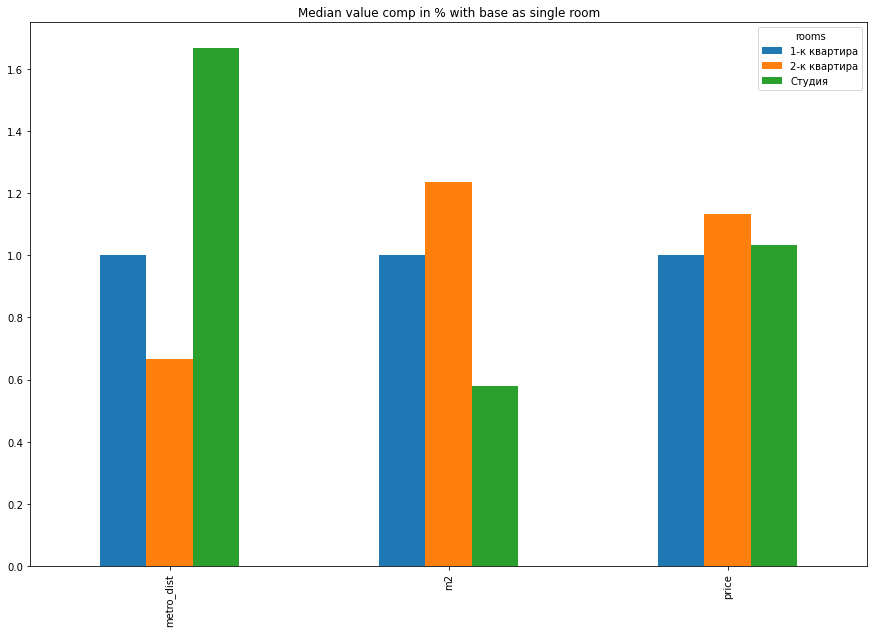

In [33]:
df.query('price<36000 &\
    metro_dist<800').groupby('rooms').median().div(\
        df.query('price<36000 &\
    metro_dist<800').groupby('rooms')\
        .median().loc['1-к квартира']).T.plot.bar(figsize=(15,10),title='Median value comp in % with base as single room')

In [174]:
metro_df=pd.read_html('https://infotables.ru/strany-i-goroda/1066-metro-moskvy-spisok-stantsij',header=0)[1]
metro_df=metro_df.dropna(subset=['№'])
metro_df=metro_df.drop(metro_df[metro_df.iloc[:,0].str.match('Спис')].index)

In [188]:
df['branch']=df['metro'].progress_apply(lambda x: metro_df.loc[metro_df.iloc[:,1].str.match(f'.+{x[1:-5]}'),'№'].values).apply(lambda x: x[0] if len(x)>0 else 'None')
col_map = {'1':'red','2':'green','3':'blue','4':'sky_blue','5':'brown','6':'orange','7':'purple','8':'yellow','8А':'sun','9':'grey','10':'grass','11':'Big_circle','11А':'Kah','12':'light_purple','15':'deep_purple'}
df['branch']=df['branch'].map(col_map)

100%|██████████| 7702/7702 [00:04<00:00, 1765.77it/s]


In [192]:
df.query('adress!="none"& 50<metro_dist<500').sort_values(by=['rubm2','metro_dist'],ascending=True).query('20000<price<41000')[:10]

,info,adress,street,dom,metro,rooms,floor,max_floors,metro_dist,m2,price,url,rubm2,branch
4608,"2-к квартира, 95 м², 21/23 эт.","ул. Академика Янгеля, 2",ул. Академика Янгеля,2,Улица академика Янгеля,2-к квартира,21,23,100.0,95.0,40000,avito.ru/moskva/kvartiry/2-k_kvartira_95_m_212...,421.052632,NaN
559,"1-к квартира, 54 м², 10/12 эт.","ул. Богданова, 48",ул. Богданова,48,Солнцево,1-к квартира,10,12,300.0,54.0,25000,avito.ru/moskva/kvartiry/1-k_kvartira_54_m_101...,462.962963,red
5671,"2-к квартира, 62 м², 2/17 эт.","ул. Липчанского, 1",ул. Липчанского,1,Некрасовка,2-к квартира,2,17,400.0,62.0,30000,avito.ru/moskva/kvartiry/2-k_kvartira_62_m_217...,483.870968,deep_purple
4945,"2-к квартира, 70 м², 7/18 эт.","ул. Липчанского, 2",ул. Липчанского,2,Некрасовка,2-к квартира,7,18,400.0,70.0,34900,avito.ru/moskva/kvartiry/2-k_kvartira_70_m_718...,498.571429,deep_purple
7504,"2-к квартира, 78 м², 2/5 эт.","2-й Карачаровский пр., 4",2-й Карачаровский пр.,4,Стахановская,2-к квартира,2,5,300.0,78.0,40000,avito.ru/moskva/kvartiry/2-k_kvartira_78_m_25_...,512.820513,NaN
4701,"2-к квартира, 60 м², 2/10 эт.","Варшавское ш., 87",Варшавское ш.,87,Варшавская,2-к квартира,2,10,100.0,60.0,31000,avito.ru/moskva/kvartiry/2-k_kvartira_60_m_210...,516.666667,Kah
5074,"2-к квартира, 58 м², 10/16 эт.","Новгородская ул., 16",Новгородская ул.,16,Алтуфьево,2-к квартира,10,16,400.0,58.0,31000,avito.ru/moskva/kvartiry/2-k_kvartira_58_m_101...,534.482759,grey
5931,"2-к квартира, 65 м², 7/17 эт.","ул. Недорубова, 11",ул. Недорубова,11,Некрасовка,2-к квартира,7,17,200.0,65.0,35000,avito.ru/moskva/kvartiry/2-k_kvartira_65_m_717...,538.461538,deep_purple
1638,"1-к квартира, 48 м², 8/14 эт.","ул. Грекова, 10",ул. Грекова,10,Медведково,1-к квартира,8,14,100.0,48.0,26000,avito.ru/moskva/kvartiry/1-k_kvartira_48_m_814...,541.666667,orange
5140,"2-к квартира, 64 м², 11/17 эт.","ул. Липчанского, 2",ул. Липчанского,2,Некрасовка,2-к квартира,11,17,400.0,64.0,35000,avito.ru/moskva/kvartiry/2-k_kvartira_64_m_111...,546.875000,deep_purple
